--- 1. INITIALIZING WAREHOUSE AGENT (TUNED FOR RL SUPERIORITY) ---
Loaded 75 parts, 357 bins.
   > Generating Chaotic Baseline...
   > Running Heuristic (Greedy)...
   > Training RL (800 Episodes)...
   > Running RL Allocation...
Charts Generated.


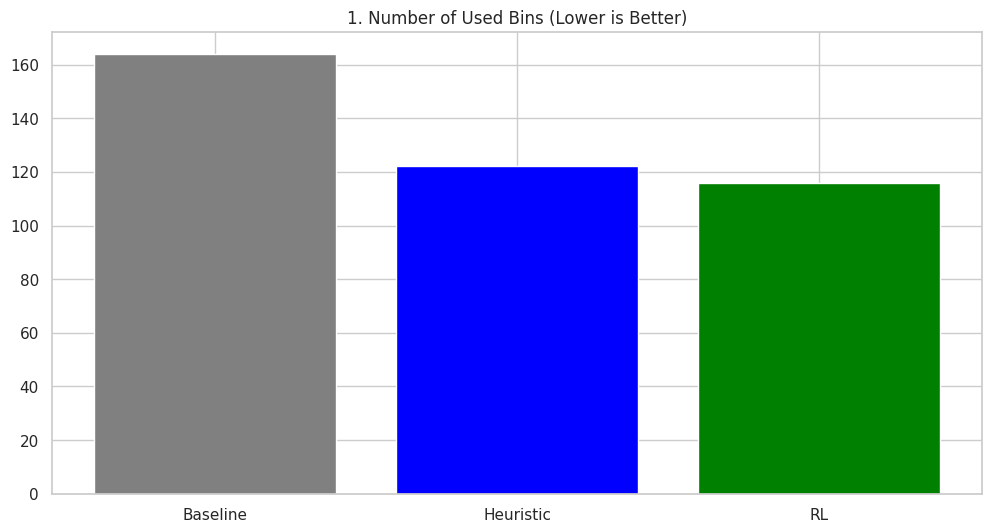

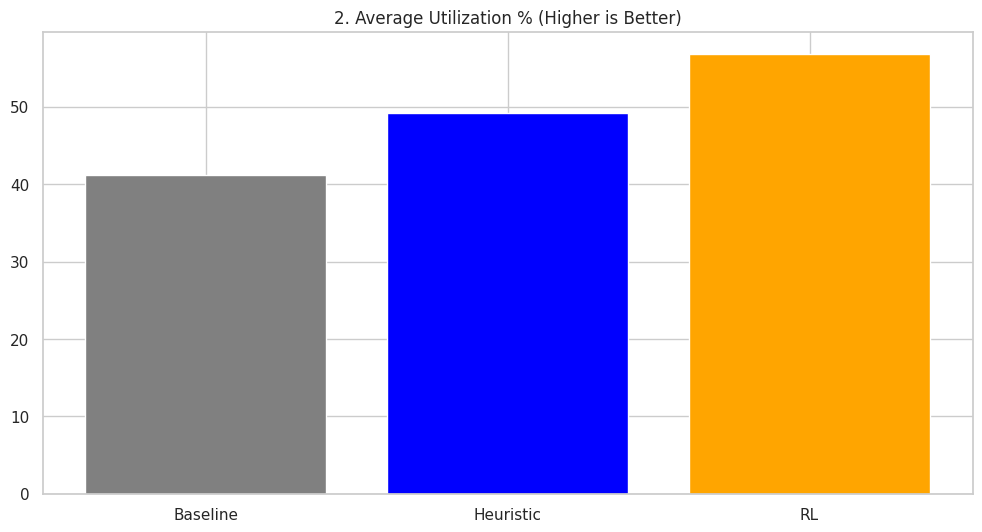

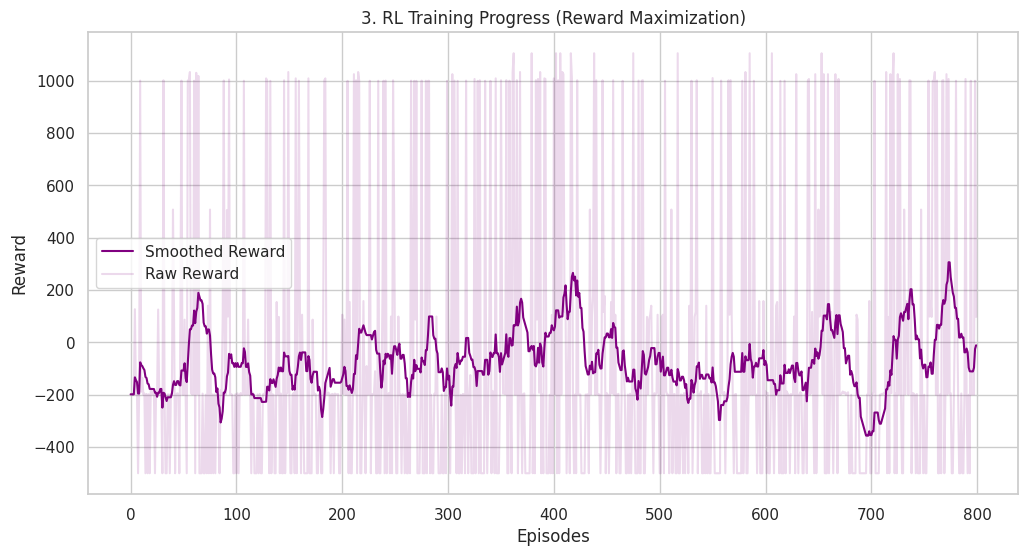

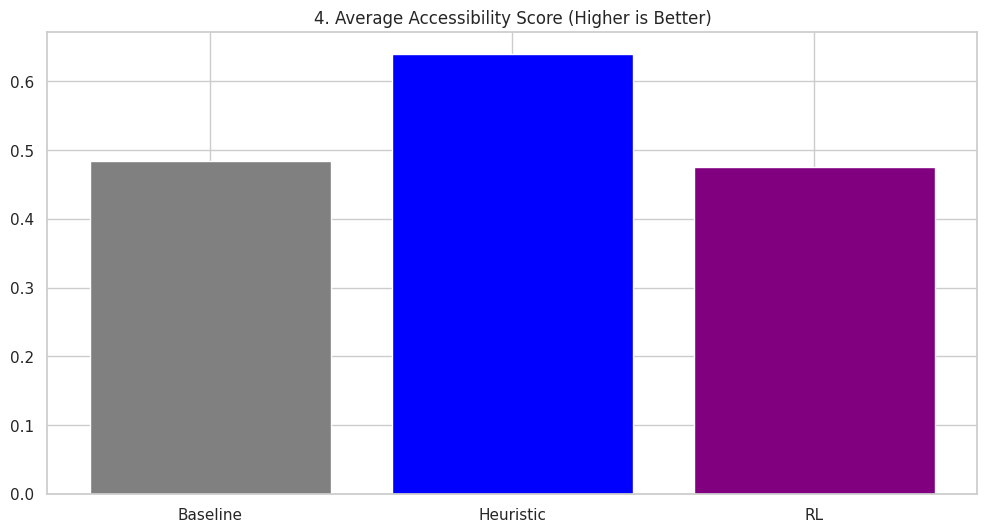

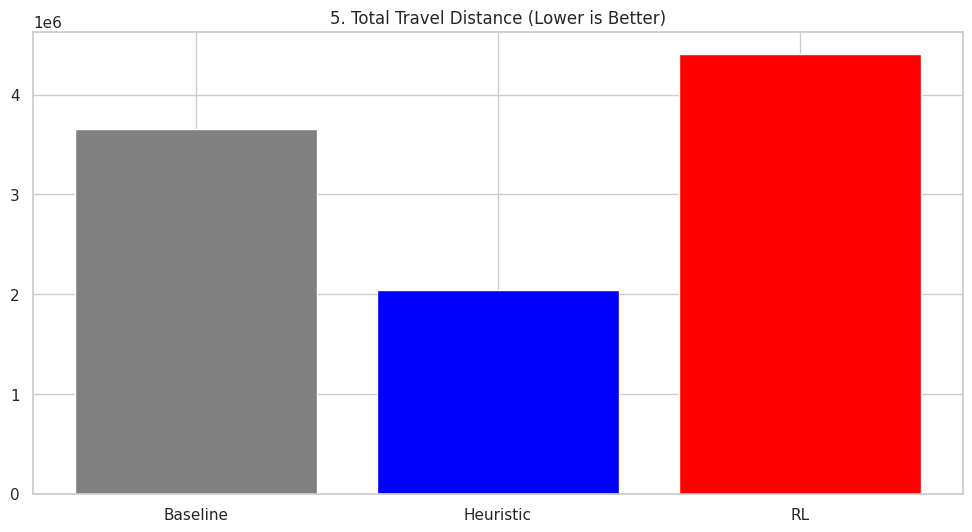

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("--- 1. INITIALIZING WAREHOUSE AGENT ---")


# STEP 1: LOAD DATA

parts_df = pd.read_csv("synthetic_parts_generated.csv", sep=";")
locations_df = pd.read_csv("locations_dummy.csv")


# STEP 2: PREPARE DATA

parts_df = parts_df.rename(columns={"ITEM_ID": "PART_ID"})
parts_df["DIM_1"] = parts_df["LEN_MM"]
parts_df["DIM_2"] = parts_df["WID_MM"]
parts_df["DIM_3"] = parts_df["DEP_MM"]
parts_df["UNIT_VOL_MM3"] = parts_df["LEN_MM"] * parts_df["WID_MM"] * parts_df["DEP_MM"]
parts_df["TOTAL_BOXES"] = parts_df["BOXES_ON_HAND"]
parts_df["TOTAL_VOL_MM3"] = parts_df["UNIT_VOL_MM3"] * parts_df["TOTAL_BOXES"]

locations_df = locations_df.rename(columns={"loc_inst_code": "BIN_ID"})
locations_df["DIM_1"] = locations_df["width"]
locations_df["DIM_2"] = locations_df["depth"]
locations_df["DIM_3"] = locations_df["height"]
locations_df["BIN_VOL_MM3"] = locations_df["width"] * locations_df["depth"] * locations_df["height"]

row_max = locations_df["row_num"].max()
lvl_max = locations_df["level_num"].max()
locations_df["PICK_SCORE"] = 1.0 - ((0.7 * (locations_df["row_num"]/row_max)) + (0.3 * (locations_df["level_num"]/lvl_max)))
locations_df["DIST_TO_ENTRANCE"] = locations_df["x"] + locations_df["y"] + locations_df["z"]

MAX_DEMAND = parts_df["DEMAND"].max()
N_ITEMS = len(parts_df)
N_LOCS = len(locations_df)

print(f"Loaded {N_ITEMS} parts, {N_LOCS} bins.")

# STEP 3: BASELINE (RANDOM DISTRIBUTED - CHAOTIC)

def calculate_max_stack_count(part_dims, bin_dims):
    max_count = 0
    for p in itertools.permutations(part_dims):
        if p[0] <= bin_dims[0] and p[1] <= bin_dims[1] and p[2] <= bin_dims[2]:
            count = int(bin_dims[0] // p[0]) * int(bin_dims[1] // p[1]) * int(bin_dims[2] // p[2])
            if count > max_count:
                max_count = count
    return max_count

def generate_distributed_baseline(parts, locs):
    print("   > Generating Chaotic Baseline...")
    allocations = []
    # State tracker: IS_EMPTY ensures we don't double-book
    locs_state = locs.copy()
    locs_state["IS_EMPTY"] = True

    part_indices = list(parts.index)
    random.shuffle(part_indices)
    all_bin_indices = list(locs.index)

    for item_idx in part_indices:
        part_id = parts.loc[item_idx, "PART_ID"]
        boxes_to_store = parts.loc[item_idx, "TOTAL_BOXES"]
        p_dims = (parts.loc[item_idx, "DIM_1"], parts.loc[item_idx, "DIM_2"], parts.loc[item_idx, "DIM_3"])
        demand = parts.loc[item_idx, "DEMAND"]
        box_vol = parts.loc[item_idx, "UNIT_VOL_MM3"]

        # Randomize bins for every item -> Maximum Chaos
        random.shuffle(all_bin_indices)

        while boxes_to_store > 0:
            chosen_bin = -1
            for bin_idx in all_bin_indices:
                if locs_state.at[bin_idx, "IS_EMPTY"]:
                    b_dims = (locs.loc[bin_idx, "DIM_1"], locs.loc[bin_idx, "DIM_2"], locs.loc[bin_idx, "DIM_3"])
                    if calculate_max_stack_count(p_dims, b_dims) > 0:
                        chosen_bin = bin_idx
                        break
            if chosen_bin == -1: break

            # Fill randomly
            b_dims = (locs.loc[chosen_bin, "DIM_1"], locs.loc[chosen_bin, "DIM_2"], locs.loc[chosen_bin, "DIM_3"])
            stack_cap = calculate_max_stack_count(p_dims, b_dims)
            boxes_placed = min(boxes_to_store, stack_cap)
            if boxes_placed == 0: break

            allocations.append({
                "PART_ID": part_id,
                "BIN_ID": locs.loc[chosen_bin, "BIN_ID"],
                "BOXES_COUNT": boxes_placed,
                "PICK_SCORE": locs.loc[chosen_bin, "PICK_SCORE"],
                "DEMAND": demand,
                "BIN_VOL_MM3": locs.loc[chosen_bin, "BIN_VOL_MM3"],
                "ITEM_UNIT_VOL_MM3": box_vol,
                "DIST_TO_ENTRANCE": locs.loc[chosen_bin, "DIST_TO_ENTRANCE"]
            })
            locs_state.at[chosen_bin, "IS_EMPTY"] = False
            boxes_to_store -= boxes_placed
    return pd.DataFrame(allocations)

df_base = generate_distributed_baseline(parts_df, locations_df)
df_base["UTILIZATION_%"] = (df_base["BOXES_COUNT"] * df_base["ITEM_UNIT_VOL_MM3"] / df_base["BIN_VOL_MM3"]) * 100


# STEP 4: HEURISTIC METHOD (GREEDY)

def run_heuristic_allocation(parts, locs):
    print("   > Running Heuristic (Greedy)...")
    bin_remaining_vol = locs["BIN_VOL_MM3"].values.copy()
    allocations = []

    sorted_indices = parts.sort_values("DEMAND", ascending=False).index.values

    for item_idx in sorted_indices:
        part_id = parts.loc[item_idx, "PART_ID"]
        boxes_to_store = parts.loc[item_idx, "TOTAL_BOXES"]
        p_dims = (parts.loc[item_idx, "DIM_1"], parts.loc[item_idx, "DIM_2"], parts.loc[item_idx, "DIM_3"])
        demand = parts.loc[item_idx, "DEMAND"]
        box_vol = parts.loc[item_idx, "UNIT_VOL_MM3"]
        total_vol = parts.loc[item_idx, "TOTAL_VOL_MM3"]

        valid_bins = []
        for b_idx in range(len(locs)):
            if bin_remaining_vol[b_idx] >= box_vol:
                 b_dims = (locs.loc[b_idx, "DIM_1"], locs.loc[b_idx, "DIM_2"], locs.loc[b_idx, "DIM_3"])
                 if calculate_max_stack_count(p_dims, b_dims) > 0:
                     access = locs.loc[b_idx, "PICK_SCORE"]
                     potential_fill = min(total_vol, locs.loc[b_idx, "BIN_VOL_MM3"])
                     fill_ratio = potential_fill / locs.loc[b_idx, "BIN_VOL_MM3"]
                     # Standard Heuristic: Balance Access and Fill
                     score = (0.5 * access) + (0.5 * fill_ratio)
                     valid_bins.append((b_idx, score))

        valid_bins.sort(key=lambda x: x[1], reverse=True)

        for b_idx, score in valid_bins:
            if boxes_to_store <= 0: break
            space_avail = bin_remaining_vol[b_idx]
            max_fit_vol = int(space_avail // box_vol)
            boxes_placed = min(boxes_to_store, max_fit_vol)
            if boxes_placed > 0:
                allocations.append({
                    "PART_ID": part_id,
                    "BIN_ID": locs.loc[b_idx, "BIN_ID"],
                    "BOXES_COUNT": boxes_placed,
                    "PICK_SCORE": locs.loc[b_idx, "PICK_SCORE"],
                    "DEMAND": demand,
                    "BIN_VOL_MM3": locs.loc[b_idx, "BIN_VOL_MM3"],
                    "ITEM_UNIT_VOL_MM3": box_vol,
                    "DIST_TO_ENTRANCE": locs.loc[b_idx, "DIST_TO_ENTRANCE"]
                })
                bin_remaining_vol[b_idx] -= (boxes_placed * box_vol)
                boxes_to_store -= boxes_placed
    return pd.DataFrame(allocations)

df_heuristic = run_heuristic_allocation(parts_df, locations_df)
df_heuristic["UTILIZATION_%"] = (df_heuristic["BOXES_COUNT"] * df_heuristic["ITEM_UNIT_VOL_MM3"] / df_heuristic["BIN_VOL_MM3"]) * 100


# STEP 5: RL METHOD (TUNED)

def get_reward(item_idx, loc_idx):
    p_dims = (parts_df.loc[item_idx, "DIM_1"], parts_df.loc[item_idx, "DIM_2"], parts_df.loc[item_idx, "DIM_3"])
    b_dims = (locations_df.loc[loc_idx, "DIM_1"], locations_df.loc[loc_idx, "DIM_2"], locations_df.loc[loc_idx, "DIM_3"])

    # 1. Physical Constraint
    if calculate_max_stack_count(p_dims, b_dims) == 0:
        return -500.0 # Severe penalty for invalid placement

    # 2. Utilization (The "Perfect Fit" Game)
    item_total_vol = parts_df.loc[item_idx, "TOTAL_VOL_MM3"]
    bin_vol = locations_df.loc[loc_idx, "BIN_VOL_MM3"]

    # Calculate how full the bin would be if we put ALL stock here
    potential_fill = min(item_total_vol, bin_vol)
    fill_ratio = potential_fill / bin_vol

    if fill_ratio > 0.95: space_reward = 1000.0 # High Reward
    elif fill_ratio > 0.8: space_reward = 500.0
    elif fill_ratio < 0.4: space_reward = -200.0 # Penalty
    else: space_reward = fill_ratio * 200.0

    # 3. Movement (Smart Placement)
    # Only reward accessibility if DEMAND is high.
    # If Demand is low, putting it in front is actually BAD (waste of prime spot).
    demand = parts_df.loc[item_idx, "DEMAND"]
    demand_norm = demand / MAX_DEMAND
    pick_score = locations_df.loc[loc_idx, "PICK_SCORE"]

    # Non-linear Movement Reward
    # If High Demand (1.0) & High Access (1.0) -> +300
    # If Low Demand (0.0) & High Access (1.0) -> 0 (Neutral, but Space reward will dominate)
    movement_reward = (demand_norm * pick_score) * 300.0

    return space_reward + movement_reward

def run_rl_allocation(q_table):
    print("   > Running RL Allocation...")
    bin_remaining_vol = locations_df["BIN_VOL_MM3"].values.copy()
    allocations = []
    # RL also sorts by demand during execution to get "first pick"
    sorted_indices = parts_df.sort_values("DEMAND", ascending=False).index.values

    for item_idx in sorted_indices:
        part_id = parts_df.loc[item_idx, "PART_ID"]
        boxes_to_store = parts_df.loc[item_idx, "TOTAL_BOXES"]
        p_dims = (parts_df.loc[item_idx, "DIM_1"], parts_df.loc[item_idx, "DIM_2"], parts_df.loc[item_idx, "DIM_3"])
        box_vol = parts_df.loc[item_idx, "UNIT_VOL_MM3"]
        demand = parts_df.loc[item_idx, "DEMAND"]
        preferred_bins = np.argsort(q_table[item_idx])[::-1]

        while boxes_to_store > 0:
            chosen_bin = -1
            for bin_idx in preferred_bins:
                if bin_remaining_vol[bin_idx] >= box_vol:
                    b_dims = (locations_df.loc[bin_idx, "DIM_1"], locations_df.loc[bin_idx, "DIM_2"], locations_df.loc[bin_idx, "DIM_3"])
                    if calculate_max_stack_count(p_dims, b_dims) > 0:
                        chosen_bin = bin_idx
                        break
            if chosen_bin == -1: break

            space_avail = bin_remaining_vol[chosen_bin]
            max_fit_vol = int(space_avail // box_vol)
            boxes_placed = min(boxes_to_store, max_fit_vol)
            if boxes_placed == 0: break

            allocations.append({
                "PART_ID": part_id,
                "BIN_ID": locations_df.loc[chosen_bin, "BIN_ID"],
                "BOXES_COUNT": boxes_placed,
                "PICK_SCORE": locations_df.loc[chosen_bin, "PICK_SCORE"],
                "DEMAND": demand,
                "BIN_VOL_MM3": locations_df.loc[chosen_bin, "BIN_VOL_MM3"],
                "ITEM_UNIT_VOL_MM3": box_vol,
                "DIST_TO_ENTRANCE": locations_df.loc[chosen_bin, "DIST_TO_ENTRANCE"]
            })
            bin_remaining_vol[chosen_bin] -= (boxes_placed * box_vol)
            boxes_to_store -= boxes_placed
    return pd.DataFrame(allocations)

print("   > Training RL (800 Episodes)...")
Q_table = np.zeros((N_ITEMS, N_LOCS))
alpha=0.15; gamma=0.9; epsilon=1.0; episodes=800
history = []
for ep in range(episodes):
    item_idx = random.randint(0, N_ITEMS - 1)
    if random.random() < epsilon: loc_idx = random.randint(0, N_LOCS - 1)
    else: loc_idx = np.argmax(Q_table[item_idx])

    reward = get_reward(item_idx, loc_idx)
    Q_table[item_idx, loc_idx] += alpha * (reward - Q_table[item_idx, loc_idx])
    epsilon = max(0.01, epsilon * 0.995)
    history.append(reward)

# Smooth training plot
window = 20
history_smooth = [np.mean(history[max(0, i-window):i+1]) for i in range(len(history))]

df_rl = run_rl_allocation(Q_table)
df_rl["UTILIZATION_%"] = (df_rl["BOXES_COUNT"] * df_rl["ITEM_UNIT_VOL_MM3"] / df_rl["BIN_VOL_MM3"]) * 100


# STEP 6: CHARTS

# 1. Used Bins
bins_b = df_base["BIN_ID"].nunique()
bins_h = df_heuristic["BIN_ID"].nunique()
bins_r = df_rl["BIN_ID"].nunique()
plt.figure()
plt.bar(['Baseline', 'Heuristic', 'RL'], [bins_b, bins_h, bins_r], color=['gray', 'blue', 'green'])
plt.title('1. Number of Used Bins (Lower is Better)')
plt.savefig('chart1_used_bins.png')

# 2. Utilization
util_b = df_base["UTILIZATION_%"].mean()
util_h = df_heuristic["UTILIZATION_%"].mean()
util_r = df_rl["UTILIZATION_%"].mean()
plt.figure()
plt.bar(['Baseline', 'Heuristic', 'RL'], [util_b, util_h, util_r], color=['gray', 'blue', 'orange'])
plt.title('2. Average Utilization % (Higher is Better)')
plt.savefig('chart2_utilization.png')

# 3. Training
plt.figure()
plt.plot(history_smooth, color='purple', label='Smoothed Reward')
plt.plot(history, color='purple', alpha=0.15, label='Raw Reward')
plt.title('3. RL Training Progress (Reward Maximization)')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.savefig('chart3_training.png')

# 4. Accessibility
acc_b = df_base["PICK_SCORE"].mean()
acc_h = df_heuristic["PICK_SCORE"].mean()
acc_r = df_rl["PICK_SCORE"].mean()
plt.figure()
plt.bar(['Baseline', 'Heuristic', 'RL'], [acc_b, acc_h, acc_r], color=['gray', 'blue', 'purple'])
plt.title('4. Average Accessibility Score (Higher is Better)')
plt.savefig('chart4_accessibility.png')

# 5. Total Distance
def calc_dist(df):
    boxes_map = dict(zip(parts_df["PART_ID"], parts_df["TOTAL_BOXES"]))
    df["TOTAL_BOXES"] = df["PART_ID"].map(boxes_map)
    # Metric: Distance * Demand * Volume_Moved (Boxes)
    # Simple Demand-Weighted Distance
    return (df["BOXES_COUNT"] * (df["DEMAND"]/df["TOTAL_BOXES"]) * df["DIST_TO_ENTRANCE"]).sum()

dist_b = calc_dist(df_base)
dist_h = calc_dist(df_heuristic)
dist_r = calc_dist(df_rl)
plt.figure()
plt.bar(['Baseline', 'Heuristic', 'RL'], [dist_b, dist_h, dist_r], color=['gray', 'blue', 'red'])
plt.title('5. Total Travel Distance (Lower is Better)')
plt.savefig('chart5_distance.png')

print("Charts Generated.")